# Setup

In [ ]:
try:
  import rtree
except ModuleNotFoundError as e:
  !apt-get install libspatialindex-dev
  !pip install rtree
  import rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 6 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (724 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144617 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_a

In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 2.7MB/s 
     |████████████████████████████████| 10.9MB 15.3MB/s 
     |████████████████████████████████| 14.8MB 311kB/s 


In [ ]:
import pandas as pd
import geopandas as gpd

---
# Exercise
- create the geodataframe of the [pharmacies of Trentino](http://servizi.apss.tn.it/opendata/FARM001.csv)
- count the total of phamarcies for each muncipality of Trentino
- list the municipalities bordering with Trento
- create the macroarea of all the municipalities bordering with Trento
- for each pharmacy contained in the macro-area, calculate how many libraries are within a 500m radius
- creates a polygon that contains all the pharmacies within a 2km radius of the Trento public library
- save the polygon in geopackage with the attribute "description" with value "area of the pharmacies 2km from the Trento public libray"
---

## data setup
geopackage with the administrative units of italy

In [ ]:
!wget https://github.com/napo/geospatial_course_unitn/raw/master/data/administrative_units_italy_2020/istat_administrative_units_2020.gpkg

--2020-10-07 12:22:57--  https://github.com/napo/geospatial_course_unitn/raw/master/data/administrative_units_italy_2020/istat_administrative_units_2020.gpkg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/administrative_units_italy_2020/istat_administrative_units_2020.gpkg [following]
--2020-10-07 12:22:58--  https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/administrative_units_italy_2020/istat_administrative_units_2020.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23396352 (22M) [application/octet-stream]
Saving to: ‘istat_ad

In [ ]:
municipalities = gpd.read_file("istat_administrative_units_2020.gpkg",layer="municipalities")

# create the geodataframe of the pharmacies of Trentino

In [ ]:
phamarcies = pd.read_csv("https://servizi.apss.tn.it/opendata/FARM001.csv")

In [ ]:
geo_phamarcies = gpd.GeoDataFrame(
    phamarcies,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(phamarcies.LONGITUDINE_P, phamarcies.LATITUDINE_P))

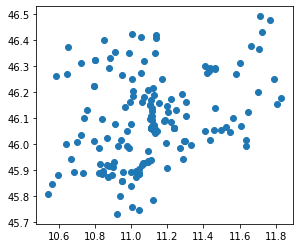

In [ ]:
geo_phamarcies.plot()

# count the total of phamarcies for each muncipality of Trentino

In [ ]:
geo_phamarcies.groupby(geo_phamarcies.COMUNE).size().to_frame("size").sort_values(['size', 'COMUNE'], ascending=[False, True])

,size
COMUNE,
TRENTO,32
ROVERETO,12
PERGINE VALSUGANA,5
ARCO,4
RIVA DEL GARDA,4
...,...
VIGOLO VATTARO,1
VILLA LAGARINA,1
VOLANO,1


# list the municipalities bordering with Trento

In [ ]:
municipalities_trentino = municipalities[municipalities.COD_PROV==22].to_crs(epsg=4326)

## Method 1 - spatial join

In [ ]:
%time
sjon_trentino_pharmacy = gpd.sjoin(municipalities_trentino,geo_phamarcies, how='inner', op='contains', lsuffix='trentino', rsuffix='pharmacy')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [ ]:
sjon_trentino_pharmacy.groupby('COMUNE_trentino').size().to_frame("size").sort_values(['size', 'COMUNE_trentino'], ascending=[False,True])

,size
COMUNE_trentino,
Trento,26
Rovereto,11
Arco,5
Pergine Valsugana,5
Riva del Garda,4
...,...
Vallarsa,1
Vallelaghi,1
Ville d'Anaunia,1


In [ ]:
sjon_trentino_pharmacy[sjon_trentino_pharmacy.COMUNE_trentino == 'Tre Ville']

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE_trentino,COMUNE_A,CC_UTS,geometry,index_pharmacy,COD_FARMACIA_OD,COD_FARMACIA,FARMACIA,IVA,CAP,COD_COMUNE,COMUNE_pharmacy,FRAZIONE,COD_PROVINCIA,PROVINCIA,COD_REGIONE,REGIONE,DATA_INIZIO,INDIRIZZO,TIPOLOGIA,LATITUDINE_P,LONGITUDINE_P,LATITUDINE_V,LONGITUDINE_V


## method 2 - loop between areas and points

In [ ]:
%time
names = []
totals = []
for idx, municipality in municipalities_trentino.iterrows():
  name = municipalities_trentino.COMUNE[idx]
  names.append(name)
  area = municipalities_trentino.geometry[idx]
  tot = 0
  for index, row in geo_phamarcies.iterrows():
    v = area.contains(geo_phamarcies.geometry[index])
    if (v):
      tot +=1
  totals.append(tot)
data = {'municipality':names, 'count_phamarcies':totals}

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [ ]:
pd.DataFrame(data).sort_values(['count_phamarcies', 'municipality'], ascending=[False,True])

,municipality,count_phamarcies
40,Trento,26
136,Rovereto,11
46,Arco,5
124,Pergine Valsugana,5
130,Riva del Garda,4
...,...,...
57,Tre Ville,0
106,Valdaone,0
41,Valfloriana,0
44,Vignola-Falesina,0


### some considerations ...

cough cough cough ... there a lot of mistakes with the coordinates in this dataset :/


find duplicate geometry

In [ ]:
onlygeometry = geo_phamarcies.geometry

In [ ]:
geo_phamarcies[onlygeometry.isin(onlygeometry[onlygeometry.duplicated()])].head(5)

,COD_FARMACIA_OD,COD_FARMACIA,FARMACIA,IVA,CAP,COD_COMUNE,COMUNE,FRAZIONE,COD_PROVINCIA,PROVINCIA,COD_REGIONE,REGIONE,DATA_INIZIO,INDIRIZZO,TIPOLOGIA,LATITUDINE_P,LONGITUDINE_P,LATITUDINE_V,LONGITUDINE_V,geometry
10,FAR042101004171,4171,ROMANI DI ERRIGO A. E C. SNC,02046850224,38015,22103,LAVIS,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2009-09-01,"VIA SEGANTINI, 1",ORDINARIA,46.151283,11.104254,"46,1512831931641","11,1042541241409",POINT (11.10425 46.15128)
13,FAR042101004174,4174,CRESCINI - DR.SSA TOGNANA,00051370229,38057,22139,PERGINE VALSUGANA,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2005-01-01,"PIAZZA SERRA, 8",ORDINARIA,46.061640,11.239847,"46,0616404","11,2398474",POINT (11.23985 46.06164)
14,FAR042101004175,4175,SCAGLIA S.A.S. DI SCAGLIA ANNA & C.,00983840224,38086,22143,PINZOLO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-07-01,"PIAZZA S. GIACOMO, 1",ORDINARIA,46.222037,10.796314,"46,2220374200605","10,7963137713744",POINT (10.79631 46.22204)
19,FAR042101004180,4180,DE BATTTAGLIA SNC,02099830222,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-02-01,"PIAZZA PASI, 20",ORDINARIA,46.062206,11.111765,"46,0622059167663","11,1117645926563",POINT (11.11176 46.06221)
32,FAR042101004193,4193,PIZZO DR. PAOLO,02030200220,38057,22139,PERGINE VALSUGANA,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2009-06-01,"VIA BELLINI, 17",ORDINARIA,46.061640,11.239847,"46,0616404","11,2398474",POINT (11.23985 46.06164)


In [ ]:
geo_phamarcies[onlygeometry.isin(onlygeometry[onlygeometry.duplicated()])].shape

(26, 20)

# create the macroarea of all the municipalities bordering with Trento

In [ ]:
trento_polygon = municipalities_trentino[municipalities_trentino.COMUNE=='Trento'].geometry.values[0]

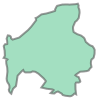

In [ ]:
trento_polygon

In [ ]:
touches_with_trento = municipalities_trentino[municipalities_trentino.geometry.touches(trento_polygon)]

In [ ]:
municipalities_around_trento = touches_with_trento.COMUNE.unique()

In [ ]:
list(municipalities_around_trento)

['Garniga Terme',
 'Giovo',
 'Cavedine',
 'Cimone',
 'Civezzano',
 'Albiano',
 'Aldeno',
 'Besenello',
 'Vallelaghi',
 'Lavis',
 'Villa Lagarina',
 'Altopiano della Vigolana',
 'Madruzzo',
 'Pergine Valsugana']

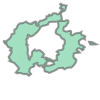

In [ ]:
touches_with_trento.geometry.unary_union

... we need to add Trento :)

## method 1 - unary_union

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


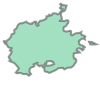

In [ ]:
%time
touches_with_trento.append(municipalities_trentino[municipalities_trentino.COMUNE=='Trento']).geometry.unary_union

## method 1 - dissolve

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


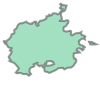

In [ ]:
%time
touches_with_trento.append(municipalities_trentino[municipalities_trentino.COMUNE=='Trento']).dissolve(by='COD_PROV').geometry.values[0]

In [ ]:
aroud_trento_area = touches_with_trento.append(municipalities_trentino[municipalities_trentino.COMUNE=='Trento']).dissolve(by='COD_PROV').geometry.values[0]

# for each pharmacy contained in the macro-area, calculate how many libraries are within a 500m radius

## step 1 - geodataframe of the libraries
note: there a lot of bad latitude and longitude in this dataset!!!

In [ ]:
libraries = pd.read_csv('http://opendata.anagrafe.iccu.sbn.it/territorio.zip', compression='zip', sep=';')

In [ ]:
libraries['latitudine'] = pd.to_numeric(libraries.latitudine.str.replace(",","."))
libraries.longitudine = pd.to_numeric(libraries.longitudine.str.replace(",","."))

In [ ]:
libraries = libraries[libraries.latitudine.isnull() == False]

In [ ]:
geo_libraries = gpd.GeoDataFrame(
    libraries,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(libraries.longitudine, libraries.latitudine))

In [ ]:
geo_libraries[geo_libraries.within(aroud_trento_area)].comune.unique()

array(['Albiano', 'Aldeno', 'Baselga di Pinè', 'Cavedine', 'Civezzano',
       'Madruzzo', 'Lavis', 'Trento', 'Altopiano della Vigolana',
       'Pergine Valsugana', 'Villa Lagarina', 'Besenello', 'Cimone',
       'Garniga Terme', 'Giovo', 'Vallelaghi', "Terre d'Adige"],
      dtype=object)

note: 

the answer confirms that there are a lot of *bad* latitude and longitude in the *dataset*

Eg: Baselga di Pinè, Terre d'Adige and Madruzzo aren't bordering with Trento

**We consire valid the dataset only for the geometries for educational purpouse**


In [ ]:
libraries_in_macroarea = geo_libraries[geo_libraries.within(aroud_trento_area)]

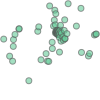

In [ ]:
libraries_in_macroarea.geometry.unary_union

## step 2 - obtain a layer with the areas (circles) of 500m radius from each libraries in macroarea

we need to calculate the distance in **meters**

In [ ]:
libraries_in_macroarea = libraries_in_macroarea.to_crs(epsg=32632)

In [ ]:
libraries_in_macroarea_500 =  libraries_in_macroarea

In [ ]:
libraries_in_macroarea_500['geometry'] = libraries_in_macroarea.buffer(500)

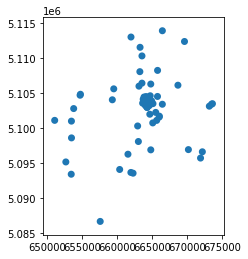

In [ ]:
libraries_in_macroarea_500.plot()

## step 3 - calculate how many lbiraries are 500m close to each phamarcy into macroarea

In [ ]:
libraries500m_from_phamarcies = gpd.sjoin(libraries_in_macroarea_500 ,geo_phamarcies.to_crs(epsg=32632), how='inner', op='contains', lsuffix='library', rsuffix='pharmacy')

In [ ]:
libraries500m_from_phamarcies

,codice-isil,codice-sbn,denominazione,indirizzo,frazione,cap,comune,codice istat comune,provincia,regione,codice istat provincia,latitudine,longitudine,telefono,fax,email,url,geometry,index_pharmacy,COD_FARMACIA_OD,COD_FARMACIA,FARMACIA,IVA,CAP,COD_COMUNE,COMUNE,FRAZIONE,COD_PROVINCIA,PROVINCIA,COD_REGIONE,REGIONE,DATA_INIZIO,INDIRIZZO,TIPOLOGIA,LATITUDINE_P,LONGITUDINE_P,LATITUDINE_V,LONGITUDINE_V
9851,IT-TN0005,NaN,Biblioteca Comunale di Albiano,via Pisetta 2,NaN,38041.0,Albiano,22002,Trento,TRENTINO-ALTO ADIGE/SÜDTIROL,22,46.144176,11.196102,+390461689033,NaN,NaN,NaN,"POLYGON ((670105.475 5112411.036, 670103.068 5...",31,FAR042101004192,4192,CREMONESI,00828140228,38041,22002,ALBIANO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2013-03-01,"VIA ROMA, 17A",ORDINARIA,46.144967,11.200060,"46,1449671070267","11,2000600793698"
9855,IT-TN0014,NaN,Biblioteca Pubblica Comunale di Baselga di Pinè,via del 26 Maggio 10,NaN,38042.0,Baselga di Pinè,22009,Trento,TRENTINO-ALTO ADIGE/SÜDTIROL,22,46.062539,11.242881,+390461557951,NaN,NaN,NaN,"POLYGON ((673974.074 5103441.695, 673971.666 5...",13,FAR042101004174,4174,CRESCINI - DR.SSA TOGNANA,00051370229,38057,22139,PERGINE VALSUGANA,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2005-01-01,"PIAZZA SERRA, 8",ORDINARIA,46.061640,11.239847,"46,0616404","11,2398474"
9941,IT-TN0160,NaN,Biblioteca Pubblica Comunale di Pergine Valsugana,piazza Serra 11,NaN,38057.0,Pergine Valsugana,22139,Trento,TRENTINO-ALTO ADIGE/SÜDTIROL,22,46.060107,11.238681,+390461502390,+39 0461531755,NaN,NaN,"POLYGON ((673656.881 5103162.258, 673654.473 5...",13,FAR042101004174,4174,CRESCINI - DR.SSA TOGNANA,00051370229,38057,22139,PERGINE VALSUGANA,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2005-01-01,"PIAZZA SERRA, 8",ORDINARIA,46.061640,11.239847,"46,0616404","11,2398474"
10031,IT-TN0588,NaN,Biblioteca dell'Istituto di istruzione Marie C...,"Via San Pietro, 4",NaN,38057.0,Pergine Valsugana,22139,Trento,TRENTINO-ALTO ADIGE/SÜDTIROL,22,46.063195,11.244537,+39 0461511397,NaN,biblioteca@curiepergine.it,https://www.curiepergine.edu.it/,"POLYGON ((674100.175 5103518.174, 674097.767 5...",13,FAR042101004174,4174,CRESCINI - DR.SSA TOGNANA,00051370229,38057,22139,PERGINE VALSUGANA,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2005-01-01,"PIAZZA SERRA, 8",ORDINARIA,46.061640,11.239847,"46,0616404","11,2398474"
9855,IT-TN0014,NaN,Biblioteca Pubblica Comunale di Baselga di Pinè,via del 26 Maggio 10,NaN,38042.0,Baselga di Pinè,22009,Trento,TRENTINO-ALTO ADIGE/SÜDTIROL,22,46.062539,11.242881,+390461557951,NaN,NaN,NaN,"POLYGON ((673974.074 5103441.695, 673971.666 5...",67,FAR042101004228,4228,DE VARDA,00182490227,38057,22139,PERGINE VALSUGANA,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2009-09-01,"VIA CESARE BATTISTI, 26",ORDINARIA,46.061640,11.239847,"46,0616404","11,2398474"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,IT-TN0214,NaN,CONSIGLIO PER LA RICERCA IN AGRICOLTURA E ANAL...,piazza NICOLINI 6,NaN,38100.0,Trento,22205,Trento,TRENTINO-ALTO ADIGE/SÜDTIROL,22,46.049048,11.145905,0461381111,+39 0461381131,NaN,WWW.CREA.GOV.IT,"POLYGON ((666514.146 5101735.841, 666511.738 5...",30,FAR042101004191,4191,VILLAZZANO DI BOLEGO PAOLO,01856020225,38123,22205,TRENTO,VILLAZZANO,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-02-01,"VIA TAMBOSI, 2",ORDINARIA,46.049783,11.143982,"46,0497829","11,1439821"
9992,IT-TN0227,NaN,Biblioteca Pubblica Comunale di Giovo,via Grec 2,NaN,38030.0,Giovo,22092,Trento,TRENTINO-ALTO ADIGE/SÜDTIROL,22,46.158767,11.155707,+390461684735,NaN,NaN,NaN,"POLYGON ((666941.786 5113946.733, 666939.378 5...",69,FAR042101004230,4230,BERNARDIN ANDREA,02443000225,38030,22092,GIOVO,VERLA,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-07-01,"VIA AI MOLINI, 1",ORDINARIA,46.155879,11.152455,"46,1558787","11,1524547"
10002,IT-TN0239,NaN,Punto di Lettura di Terlago,via Roma 10,NaN,38096.0,Vallelaghi,22248,Trento,TRENTINO-ALTO ADIGE/SÜDTIROL,22,46.079850,11.001164,+390461860150,NaN,NaN,NaN

**note:**

... there are **bad values** about latitude and logitude in **both** original **datasets**

In [ ]:
libraries500m_from_phamarcies.groupby('comune').size().to_frame("size").sort_values(['size', 'comune'], ascending=[False,True])

,size
comune,
Trento,115
Pergine Valsugana,8
Baselga di Pinè,4
Civezzano,2
Vallelaghi,2
Albiano,1
Altopiano della Vigolana,1
Cavedine,1
Giovo,1


# create a polygon that contains all the pharmacies within a 2km radius of the Trento public library

we need the geometry of the public library of Trento in meters


In [ ]:
trento_public_library = geo_libraries[geo_libraries['codice-isil'] == 'IT-TN0121'].to_crs(epsg=32632).geometry.values[0]

## Solution 1

calculate the distance from the position for each phamarcy

In [ ]:
geo_phamarcies['distance'] = geo_phamarcies.to_crs(epsg=32632).geometry.distance(trento_public_library)

In [ ]:
phamarcies_2000m_from_public_library_trento = geo_phamarcies[geo_phamarcies['distance'] < 2000.0]

In [ ]:
phamarcies_2000m_from_public_library_trento

,COD_FARMACIA_OD,COD_FARMACIA,FARMACIA,IVA,CAP,COD_COMUNE,COMUNE,FRAZIONE,COD_PROVINCIA,PROVINCIA,COD_REGIONE,REGIONE,DATA_INIZIO,INDIRIZZO,TIPOLOGIA,LATITUDINE_P,LONGITUDINE_P,LATITUDINE_V,LONGITUDINE_V,geometry,distance
17,FAR042101004178,4178,DALL'ARMI SNC PATTINI DR. ALBERTO E DR.SSA ALE...,00337140222,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-02-01,"PIAZZA DUOMO, 10",ORDINARIA,46.067619,11.121519,"46,0676193498462","11,1215188143335",POINT (11.12152 46.06762),243.486471
19,FAR042101004180,4180,DE BATTTAGLIA SNC,02099830222,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-02-01,"PIAZZA PASI, 20",ORDINARIA,46.062206,11.111765,"46,0622059167663","11,1117645926563",POINT (11.11176 46.06221),1091.193285
25,FAR042101004186,4186,BOLGHERA SNC,00166280222,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-07-01,"LARGO MEDAGLIE D'ORO, 8",ORDINARIA,46.057797,11.132752,"46,0577971934673","11,1327523327511",POINT (11.13275 46.05780),1619.147637
87,FAR042101004250,4250,LEPORE DR. MARCO,00639430222,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-02-01,"VIA MANZONI, 7/A",ORDINARIA,46.074813,11.125135,"46,0748132409383","11,1251346567747",POINT (11.12513 46.07481),655.432357
88,FAR042101004251,4251,ALLA MADONNA DR. GIANMARCO CASAGRANDE & C. SNC,01735670224,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2013-03-01,"VIA G. MANCI, 42",ORDINARIA,46.062206,11.111765,"46,0622059167663","11,1117645926563",POINT (11.11176 46.06221),1091.193285
98,FAR042101004261,4261,SAN LORENZO,01709540221,38121,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-02-01,"PIAZZA G. CANTORE, 1",ORDINARIA,46.069692,11.121089,"46,0696924","11,1210886",POINT (11.12109 46.06969),23.992939
101,FAR042101004264,4264,BETTA MARCO,01457840229,38123,22205,TRENTO,RAVINA,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-02-01,"VIA HERRSCHING, 1",ORDINARIA,46.062206,11.111765,"46,0622059167663","11,1117645926563",POINT (11.11176 46.06221),1091.193285
105,FAR042101004270,4270,FERRI,00661510222,38121,22205,TRENTO,MARTIGNANO,TN,TRENTO,42,PROV. AUTON. TRENTO,2013-03-01,"VIA FORMIGHETA, 1",ORDINARIA,46.069692,11.121089,"46,0696924","11,1210886",POINT (11.12109 46.06969),23.992939
107,FAR042101004272,4272,DE GERLONI DR. PIER FRANCESCO,01229140221,38123,22205,TRENTO,"SOPRAMONTE, 205 F",TN,TRENTO,42,PROV. AUTON. TRENTO,2013-03-01,"LOC. SOPRAMONTE, 205 F",ORDINARIA,46.062206,11.111765,"46,0622059167663","11,1117645926563",POINT (11.11176 46.06221),1091.193285
117,FAR042101016627,16627,COMUNALE SAN GIUSEPPE,01581140223,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-07-01,"VIA VITTORIO VENETO, 39",ORDINARIA,46.058852,11.124785,"46,05885165","11,1247846",POINT (11.12478 46.05885),1250.157477


## solution 2

In [ ]:
trento_public_library_2k = trento_public_library.buffer(2000)

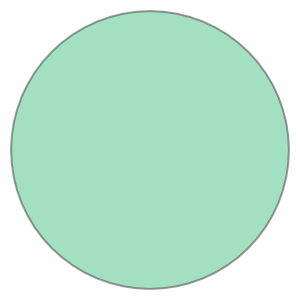

In [ ]:
trento_public_library_2k

In [ ]:
phamarcies_2000m_from_public_library_trento = geo_phamarcies[geo_phamarcies.to_crs(epsg=32632).within(trento_public_library_2k)]

In [ ]:
phamarcies_2000m_from_public_library_trento

,COD_FARMACIA_OD,COD_FARMACIA,FARMACIA,IVA,CAP,COD_COMUNE,COMUNE,FRAZIONE,COD_PROVINCIA,PROVINCIA,COD_REGIONE,REGIONE,DATA_INIZIO,INDIRIZZO,TIPOLOGIA,LATITUDINE_P,LONGITUDINE_P,LATITUDINE_V,LONGITUDINE_V,geometry,distance
17,FAR042101004178,4178,DALL'ARMI SNC PATTINI DR. ALBERTO E DR.SSA ALE...,00337140222,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-02-01,"PIAZZA DUOMO, 10",ORDINARIA,46.067619,11.121519,"46,0676193498462","11,1215188143335",POINT (11.12152 46.06762),243.486471
19,FAR042101004180,4180,DE BATTTAGLIA SNC,02099830222,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-02-01,"PIAZZA PASI, 20",ORDINARIA,46.062206,11.111765,"46,0622059167663","11,1117645926563",POINT (11.11176 46.06221),1091.193285
25,FAR042101004186,4186,BOLGHERA SNC,00166280222,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-07-01,"LARGO MEDAGLIE D'ORO, 8",ORDINARIA,46.057797,11.132752,"46,0577971934673","11,1327523327511",POINT (11.13275 46.05780),1619.147637
87,FAR042101004250,4250,LEPORE DR. MARCO,00639430222,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-02-01,"VIA MANZONI, 7/A",ORDINARIA,46.074813,11.125135,"46,0748132409383","11,1251346567747",POINT (11.12513 46.07481),655.432357
88,FAR042101004251,4251,ALLA MADONNA DR. GIANMARCO CASAGRANDE & C. SNC,01735670224,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2013-03-01,"VIA G. MANCI, 42",ORDINARIA,46.062206,11.111765,"46,0622059167663","11,1117645926563",POINT (11.11176 46.06221),1091.193285
98,FAR042101004261,4261,SAN LORENZO,01709540221,38121,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-02-01,"PIAZZA G. CANTORE, 1",ORDINARIA,46.069692,11.121089,"46,0696924","11,1210886",POINT (11.12109 46.06969),23.992939
101,FAR042101004264,4264,BETTA MARCO,01457840229,38123,22205,TRENTO,RAVINA,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-02-01,"VIA HERRSCHING, 1",ORDINARIA,46.062206,11.111765,"46,0622059167663","11,1117645926563",POINT (11.11176 46.06221),1091.193285
105,FAR042101004270,4270,FERRI,00661510222,38121,22205,TRENTO,MARTIGNANO,TN,TRENTO,42,PROV. AUTON. TRENTO,2013-03-01,"VIA FORMIGHETA, 1",ORDINARIA,46.069692,11.121089,"46,0696924","11,1210886",POINT (11.12109 46.06969),23.992939
107,FAR042101004272,4272,DE GERLONI DR. PIER FRANCESCO,01229140221,38123,22205,TRENTO,"SOPRAMONTE, 205 F",TN,TRENTO,42,PROV. AUTON. TRENTO,2013-03-01,"LOC. SOPRAMONTE, 205 F",ORDINARIA,46.062206,11.111765,"46,0622059167663","11,1117645926563",POINT (11.11176 46.06221),1091.193285
117,FAR042101016627,16627,COMUNALE SAN GIUSEPPE,01581140223,38122,22205,TRENTO,-,TN,TRENTO,42,PROV. AUTON. TRENTO,2017-07-01,"VIA VITTORIO VENETO, 39",ORDINARIA,46.058852,11.124785,"46,05885165","11,1247846",POINT (11.12478 46.05885),1250.157477


**note**:

there are always data with wrong latitude and longitude

Here how to find the rows with the duplicated geometries

In [ ]:
onlygeometry_phamarcy = phamarcies_2000m_from_public_library_trento.geometry

In [ ]:
toremove = phamarcies_2000m_from_public_library_trento[onlygeometry_phamarcy.isin(onlygeometry_phamarcy[onlygeometry.duplicated()])]

In [ ]:
list(toremove.COD_FARMACIA_OD)

['FAR042101004180',
 'FAR042101004251',
 'FAR042101004261',
 'FAR042101004264',
 'FAR042101004270',
 'FAR042101004272',
 'FAR042101016665',
 'FAR042101016677',
 'FAR042101018181',
 'FAR042101018834']

In [ ]:
final_dataset = phamarcies_2000m_from_public_library_trento[~phamarcies_2000m_from_public_library_trento.COD_FARMACIA_OD.isin(list(toremove.COD_FARMACIA_OD))]

In [ ]:
final_dataset = final_dataset.reset_index()

## convex hull

![](https://media.geeksforgeeks.org/wp-content/uploads/ConvexHull.png)

In geometry, the convex hull or convex envelope or convex closure of a shape is the smallest convex set that contains it. The convex hull may be defined either as the intersection of all convex sets containing a given subset of a Euclidean space, or equivalently as the set of all convex combinations of points in the subset. For a bounded subset of the plane, the convex hull may be visualized as the shape enclosed by a rubber band stretched around the subset. (source: [Wikipedia](https://en.wikipedia.org/wiki/Convex_hull))


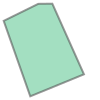

In [ ]:
final_dataset.geometry.unary_union.convex_hull

# save the polygon in geopackage with the attribute "description" with value "area of the pharmacies 2km from the Trento public libray"

In [ ]:
polygon = final_dataset.geometry.unary_union.convex_hull

In [ ]:
d = {'description': ['area of the pharmacies 2km from the Trento public libray'], 'geometry': [polygon]}

In [ ]:
phamarcies2k = gpd.GeoDataFrame(d, crs=final_dataset.crs)

In [ ]:
phamarcies2k.to_file("phamarcies2k_to_pl_trento.gpkg",driver="GPKG",layer='phamarcies')

In [ ]:
from google.colab import files
files.download('phamarcies2k_to_pl_trento.gpkg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>